In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

cust = pd.read_csv("Customer_info.csv")
disc = pd.read_csv("Discount_info.csv")
mark = pd.read_csv("Marketing_info.csv")
O_sale = pd.read_csv("Onlinesales_info.csv")

import warnings
warnings.filterwarnings("ignore")  # 모든 경고 무시

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 기호(-) 깨짐 방지


# 데이터 탐색

In [2]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   고객ID    1468 non-null   object
 1   성별      1468 non-null   object
 2   고객지역    1468 non-null   object
 3   가입기간    1468 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 46.0+ KB


In [3]:
O_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   고객ID    52924 non-null  object 
 1   거래ID    52924 non-null  object 
 2   거래날짜    52924 non-null  object 
 3   제품ID    52924 non-null  object 
 4   제품카테고리  52924 non-null  object 
 5   수량      52924 non-null  int64  
 6   평균금액    52924 non-null  float64
 7   배송료     52924 non-null  float64
 8   쿠폰상태    52924 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.6+ MB


In [4]:
cust

,고객ID,성별,고객지역,가입기간
0,USER_1358,남,Chicago,12
1,USER_0190,남,California,43
2,USER_0066,남,Chicago,33
3,USER_0345,여,California,30
4,USER_0683,남,California,49
...,...,...,...,...
1463,USER_0513,여,New York,41
1464,USER_0167,여,Chicago,48
1465,USER_0845,남,New Jersey,19
1466,USER_0504,여,New York,45


# RFM 분석

- Recency(최근 거래날짜 생성)

In [5]:
O_sale['거래날짜'] = pd.to_datetime(O_sale['거래날짜'])
last = O_sale['거래날짜'].max() + pd.DateOffset(days=1)

rfm_df = O_sale.groupby(['고객ID']).agg({
    '거래날짜': lambda x: (last - x.max()).days})
cust = cust.merge(rfm_df, on='고객ID', how= 'left')
cust = cust.rename(columns = {"거래날짜" : "Recency"})

In [6]:
last

Timestamp('2020-01-01 00:00:00')

- Frequency 피처생성(Frequency)

In [7]:
#Frequency
transaction_count = O_sale.groupby('고객ID')['거래ID'].nunique().reset_index()
transaction_count.columns = ['고객ID', 'Frequency']
cust = cust.merge(transaction_count, on='고객ID', how='left')

- Monetary피처 생성

In [8]:
O_sale['Monetary'] = O_sale['수량']*O_sale['평균금액']

ID_total_price = O_sale.groupby('고객ID')['Monetary'].sum().reset_index()

cust = cust.merge(ID_total_price , on='고객ID', how='left')

In [9]:
cust

,고객ID,성별,고객지역,가입기간,Recency,Frequency,Monetary
0,USER_1358,남,Chicago,12,340,177,34551.40
1,USER_0190,남,California,43,14,26,3048.79
2,USER_0066,남,Chicago,33,152,15,2361.48
3,USER_0345,여,California,30,365,1,1.24
4,USER_0683,남,California,49,124,6,1043.72
...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,1,5,506.88
1464,USER_0167,여,Chicago,48,1,14,3002.01
1465,USER_0845,남,New Jersey,19,1,3,735.29
1466,USER_0504,여,New York,45,1,6,1108.99


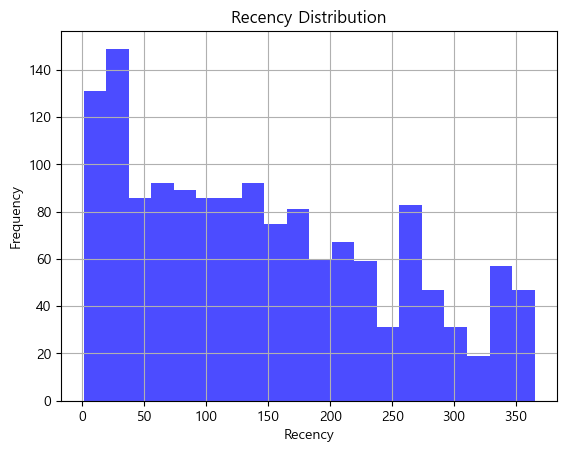

In [10]:
import matplotlib.pyplot as plt

# Recency 분포 확인
plt.hist(cust['Recency'], bins=20, alpha=0.7, color='blue')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('Recency Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

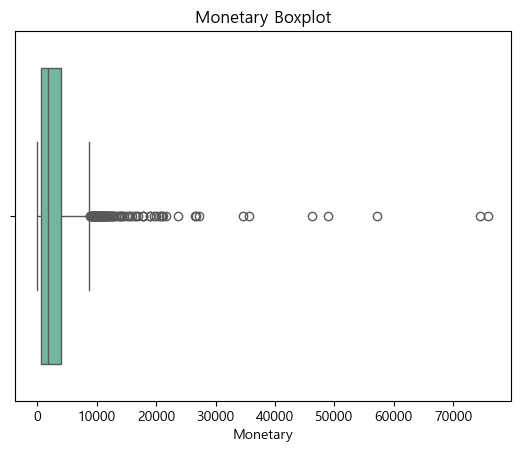

In [11]:
import seaborn as sns

# Monetary 이상치 탐색
sns.boxplot(data=cust, x='Monetary', palette='Set2')
plt.title('Monetary Boxplot')
plt.savefig('Monetary Boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

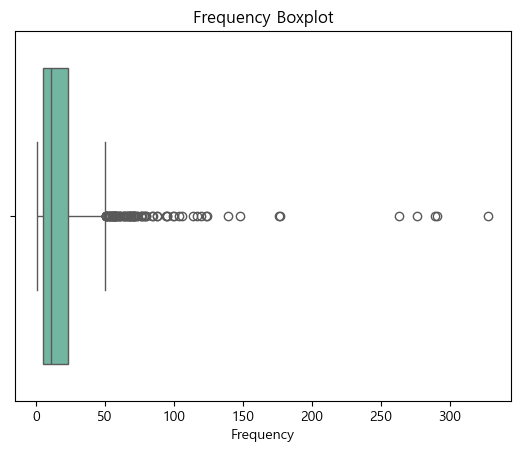

In [12]:
import seaborn as sns

#Frequency 이상치 탐색
sns.boxplot(data=cust, x='Frequency', palette='Set2')
plt.title('Frequency Boxplot')
plt.savefig('Frequency Boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

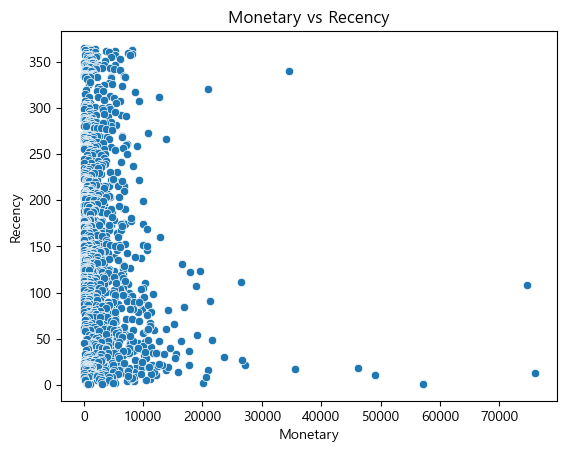

In [13]:
sns.scatterplot(x= cust['Monetary'], y=cust['Recency'])
plt.title('Monetary vs Recency')  # 제목 추가
plt.show()

- 데이터 특성상 이상치도 의미있을 수 있음
- 그렇지만 좀더 직관적으로 보기 위해 R,F,M 등급을 의미하는 피처 생성

# R피처생성

In [14]:
# Rececy는 now - 최근구매일자이므로 작을수록 최근값을 의미함 
cust['R'] = pd.qcut(cust['Recency'], q=4, labels=[4, 3, 2, 1]) # 역순으로 할당하여 값이 최근 구매일 수록 R값 높게

# 결과 확인


In [15]:
cust['Recency'].quantile(0.25)

56.0

In [16]:
cust['R'].value_counts()

R
3    372
4    369
1    366
2    361
Name: count, dtype: int64

# F 피처 생성

In [17]:
cust['F'] = pd.qcut(cust['Frequency'], q=4, labels=[1, 2, 3, 4])

In [18]:
cust['F'].value_counts()

F
1    416
4    366
2    349
3    337
Name: count, dtype: int64

# M 피처생성

In [19]:
# 상위 5%의 고객을 VIP로 설정
threshold = cust['Monetary'].quantile(0.90)  # 상위 5% 기준값
vip_customers = cust[cust['Monetary'] > threshold]
print(f"VIP 고객 수: {len(vip_customers)}")



VIP 고객 수: 147


In [20]:
import pandas as pd

# 예제 데이터 생성

# 1사분위(Q1), 3사분위(Q3), 95% 분위 계산
Q1 = cust['Monetary'].quantile(0.25)  # 1사분위
Q3 = cust['Monetary'].quantile(0.75)  # 3사분위
upper_5_percent = cust['Monetary'].quantile(0.95)  # 상위 5%

# 1.5 분위 하한 계산
Q30 = cust['Monetary'].quantile(0.3)  # 30%
Q70 = cust['Monetary'].quantile(0.6)  # 70%
Q90 = cust['Monetary'].quantile(0.90)  # 95%

# 구간 경계 설정
bins = [0, Q30, Q70, Q90, float('inf')]  # 0 ~ 30% ~ 70% ~ 90% ~ 상위
labels = [1, 2, 3, 4]  # 각 구간에 부여할 값

# 구간화
cust['M'] = pd.cut(cust['Monetary'], bins=bins, labels=labels, include_lowest=True)

# 결과 확인
cust


,고객ID,성별,고객지역,가입기간,Recency,Frequency,Monetary,R,F,M
0,USER_1358,남,Chicago,12,340,177,34551.40,1,4,4
1,USER_0190,남,California,43,14,26,3048.79,4,4,3
2,USER_0066,남,Chicago,33,152,15,2361.48,2,3,2
3,USER_0345,여,California,30,365,1,1.24,1,1,1
4,USER_0683,남,California,49,124,6,1043.72,3,2,2
...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,1,5,506.88,4,1,1
1464,USER_0167,여,Chicago,48,1,14,3002.01,4,3,3
1465,USER_0845,남,New Jersey,19,1,3,735.29,4,1,1
1466,USER_0504,여,New York,45,1,6,1108.99,4,2,2


In [21]:
cust['M'].value_counts()

M
1    441
2    440
3    440
4    147
Name: count, dtype: int64

In [22]:
cust

,고객ID,성별,고객지역,가입기간,Recency,Frequency,Monetary,R,F,M
0,USER_1358,남,Chicago,12,340,177,34551.40,1,4,4
1,USER_0190,남,California,43,14,26,3048.79,4,4,3
2,USER_0066,남,Chicago,33,152,15,2361.48,2,3,2
3,USER_0345,여,California,30,365,1,1.24,1,1,1
4,USER_0683,남,California,49,124,6,1043.72,3,2,2
...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,1,5,506.88,4,1,1
1464,USER_0167,여,Chicago,48,1,14,3002.01,4,3,3
1465,USER_0845,남,New Jersey,19,1,3,735.29,4,1,1
1466,USER_0504,여,New York,45,1,6,1108.99,4,2,2


- rfm 등급값을 기반으로 kmeans로 군집화하기 위해 실루엣 계수와 SSE 값 그래프 확인

Elbow Method에서 최적의 클러스터 개수: 1
Silhouette Analysis에서 최적의 클러스터 개수: 5


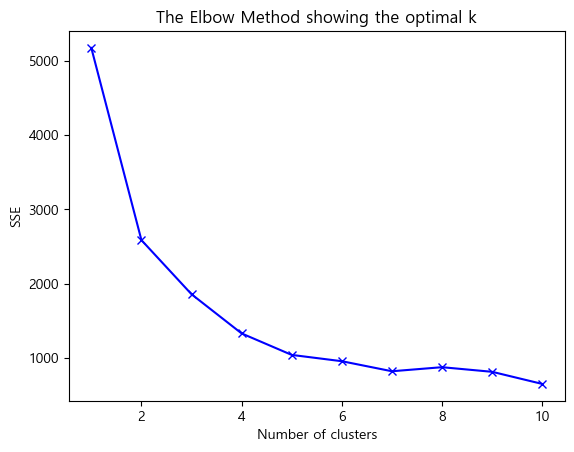

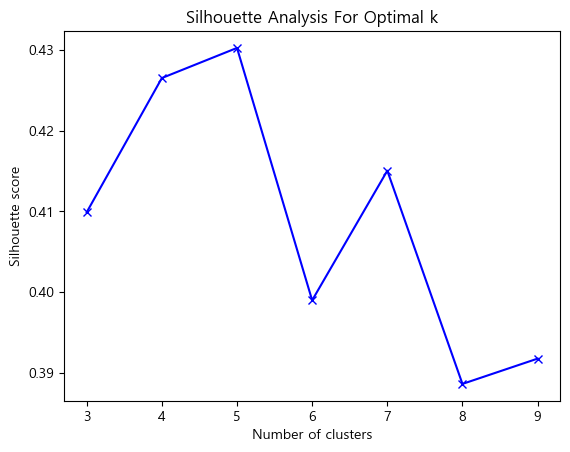

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


rfm = cust[['R', 'F', 'M']]

# Elbow Method로 SSE 계산 및 최적 K 구하기
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm)
    sse[k] = kmeans.inertia_  # SSE for each n_clusters

# Elbow Method를 통해 최적 K 추정
optimal_k_elbow = min(sse, key=lambda k: sse[k+1] - sse[k] if k+1 in sse else float('inf'))

print(f"Elbow Method에서 최적의 클러스터 개수: {optimal_k_elbow}")

# Silhouette 점수를 통해 최적 K 구하기
silhouette_scores = {}
for k in range(3, 10):  # Silhouette Score는 2 이상부터 계산 가능
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm)
    score = silhouette_score(rfm, kmeans.labels_)
    silhouette_scores[k] = score

optimal_k_silhouette = max(silhouette_scores, key=silhouette_scores.get)

print(f"Silhouette Analysis에서 최적의 클러스터 개수: {optimal_k_silhouette}")

# SSE 값 시각화
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Silhouette 점수 시각화
plt.figure()
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title('Silhouette Analysis For Optimal k')
plt.show()


- 그래프를 근거로 5개로 선정

In [24]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(cust[['R','F','M']])  # 클러스터링에 사용할 수치형 변수들

KMeans(n_clusters=5, random_state=42)

In [25]:
cust['Cluster_n'] = kmeans.labels_
cust['Cluster_n'].value_counts()

Cluster_n
2    453
1    293
0    274
4    251
3    197
Name: count, dtype: int64

In [26]:
cust

,고객ID,성별,고객지역,가입기간,Recency,Frequency,Monetary,R,F,M,Cluster_n
0,USER_1358,남,Chicago,12,340,177,34551.40,1,4,4,0
1,USER_0190,남,California,43,14,26,3048.79,4,4,3,4
2,USER_0066,남,Chicago,33,152,15,2361.48,2,3,2,0
3,USER_0345,여,California,30,365,1,1.24,1,1,1,2
4,USER_0683,남,California,49,124,6,1043.72,3,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,1,5,506.88,4,1,1,1
1464,USER_0167,여,Chicago,48,1,14,3002.01,4,3,3,3
1465,USER_0845,남,New Jersey,19,1,3,735.29,4,1,1,1
1466,USER_0504,여,New York,45,1,6,1108.99,4,2,2,1


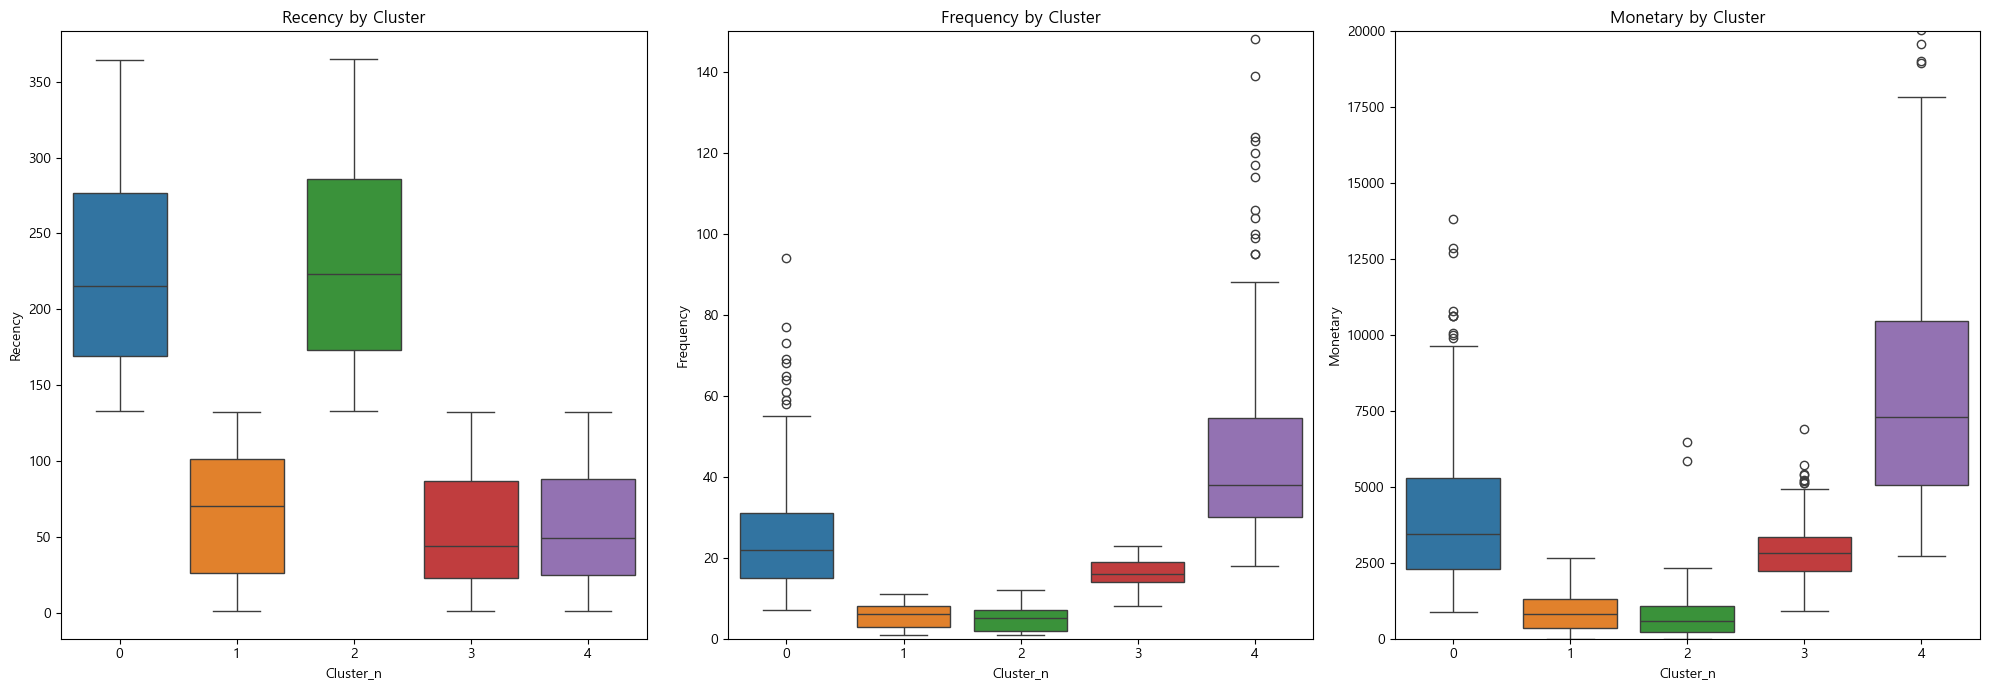

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
fig, axs = plt.subplots(ncols=3, figsize=(20, 7))

# Recency에 대한 박스플롯
sns.boxplot(data=cust, x='Cluster_n', y='Recency', ax=axs[0], palette="tab10")
axs[0].set_title('Recency by Cluster')
axs[0].set_xlabel('Cluster_n')
axs[0].set_ylabel('Recency')

# Frequency에 대한 박스플롯
sns.boxplot(data=cust, x='Cluster_n', y='Frequency', ax=axs[1], palette="tab10")
axs[1].set_title('Frequency by Cluster')
axs[1].set_xlabel('Cluster_n')
axs[1].set_ylabel('Frequency')
axs[1].set_ylim(0, 150)
# Monetary에 대한 박스플롯
sns.boxplot(data=cust, x='Cluster_n', y='Monetary', ax=axs[2], palette="tab10")
axs[2].set_title('Monetary by Cluster')
axs[2].set_xlabel('Cluster_n')
axs[2].set_ylabel('Monetary')
axs[2].set_ylim(0, 20000)  # axs[1]에 ylim 설정


# 레이아웃 조정
plt.tight_layout()
plt.show()


In [28]:
cust

,고객ID,성별,고객지역,가입기간,Recency,Frequency,Monetary,R,F,M,Cluster_n
0,USER_1358,남,Chicago,12,340,177,34551.40,1,4,4,0
1,USER_0190,남,California,43,14,26,3048.79,4,4,3,4
2,USER_0066,남,Chicago,33,152,15,2361.48,2,3,2,0
3,USER_0345,여,California,30,365,1,1.24,1,1,1,2
4,USER_0683,남,California,49,124,6,1043.72,3,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,1,5,506.88,4,1,1,1
1464,USER_0167,여,Chicago,48,1,14,3002.01,4,3,3,3
1465,USER_0845,남,New Jersey,19,1,3,735.29,4,1,1,1
1466,USER_0504,여,New York,45,1,6,1108.99,4,2,2,1


In [29]:
cust_0 = cust[cust["Cluster_n"] == 0]

In [30]:
cust_0['R'].value_counts()

R
2    146
1    128
4      0
3      0
Name: count, dtype: int64

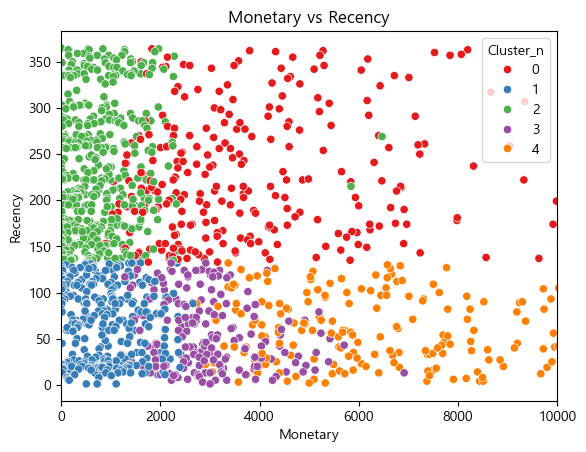

In [31]:
sns.scatterplot(x= cust['Monetary'], y=cust['Recency'], hue = cust.Cluster_n,  palette='Set1')
plt.title('Monetary vs Recency')  # 제목 추가
plt.xlim(0, 10000)
plt.show()

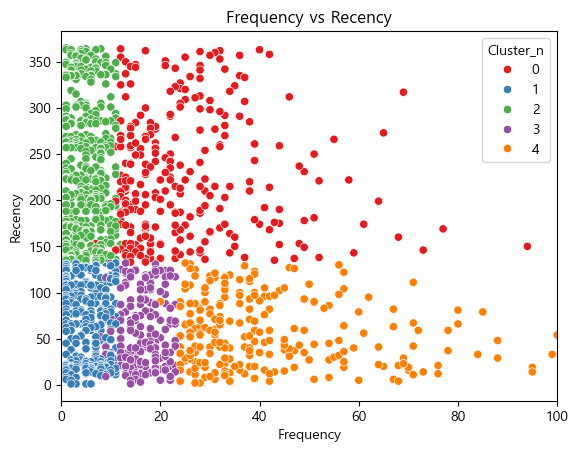

In [32]:
sns.scatterplot(x= cust['Frequency'], y=cust['Recency'], hue = cust.Cluster_n,  palette='Set1')
plt.title('Frequency vs Recency')  # 제목 추가

plt.xlim(0, 100)
plt.show()

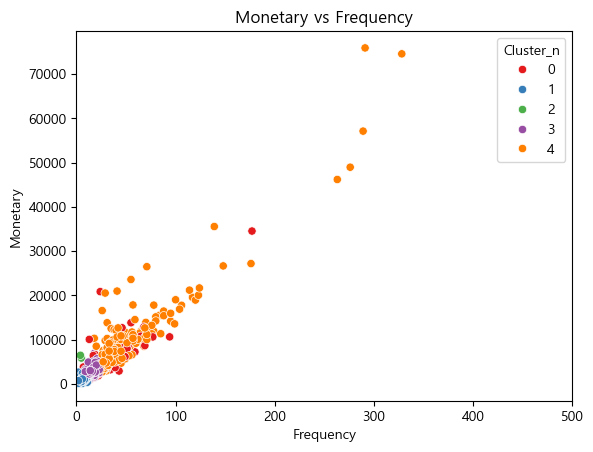

In [33]:
sns.scatterplot(x= cust['Frequency'], y=cust['Monetary'], hue = cust.Cluster_n,  palette='Set1')
plt.title('Monetary vs Frequency')  # 제목 추가
plt.xlim(0, 500)
plt.show()

In [34]:
# IQR 기반 이상치 경계 계산 및 clip 적용 함수
def adjust_outliers_with_clip(df, column):
    Q1 = df[column].quantile(0.25)  # 1분위
    Q3 = df[column].quantile(0.75)  # 3분위
    IQR = Q3 - Q1                   # IQR 계산
    lower_bound = Q1 - 1.5 * IQR    # 하한
    upper_bound = Q3 + 1.5 * IQR    # 상한
    # clip을 사용하여 이상치를 하한과 상한으로 조정
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Recency, Frequency, Monetary에 대해 이상치 조정
columns_to_adjust = ['Recency', 'Frequency', 'Monetary']
for col in columns_to_adjust:
    cust = adjust_outliers_with_clip(cust, col)

# 조정된 데이터 확인
cust

,고객ID,성별,고객지역,가입기간,Recency,Frequency,Monetary,R,F,M,Cluster_n
0,USER_1358,남,Chicago,12,340,50,8816.10,1,4,4,0
1,USER_0190,남,California,43,14,26,3048.79,4,4,3,4
2,USER_0066,남,Chicago,33,152,15,2361.48,2,3,2,0
3,USER_0345,여,California,30,365,1,1.24,1,1,1,2
4,USER_0683,남,California,49,124,6,1043.72,3,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,1,5,506.88,4,1,1,1
1464,USER_0167,여,Chicago,48,1,14,3002.01,4,3,3,3
1465,USER_0845,남,New Jersey,19,1,3,735.29,4,1,1,1
1466,USER_0504,여,New York,45,1,6,1108.99,4,2,2,1


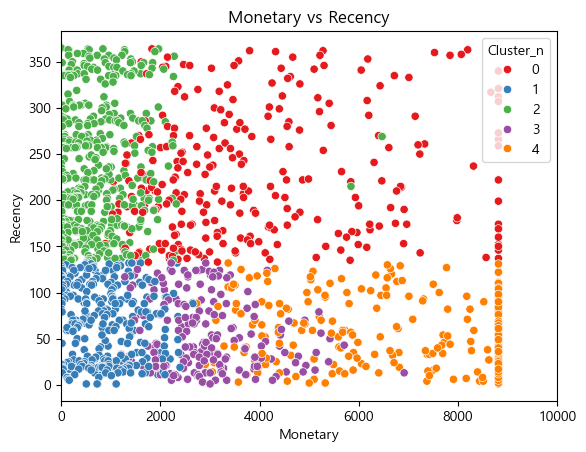

In [35]:
sns.scatterplot(x= cust['Monetary'], y=cust['Recency'], hue = cust.Cluster_n,  palette='Set1')
plt.title('Monetary vs Recency')  # 제목 추가
plt.xlim(0, 10000)
plt.show()

In [36]:
cust[['R','F','M']] = cust[['R','F','M']].astype(int)

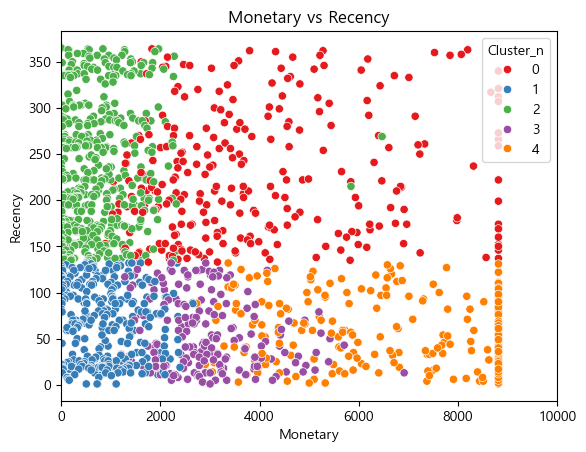

In [37]:
sns.scatterplot(x= cust['Monetary'], y=cust['Recency'], hue = cust.Cluster_n,  palette='Set1')
plt.title('Monetary vs Recency')  # 제목 추가
plt.xlim(0, 10000)
plt.show()

#### 산점도보면 **구간화한 등급값**으로 클러스터링했기 때문에 군집화가 덜 되었다고 판단, **구간화이전의 값을 고려하여 추가적으로 세분화**

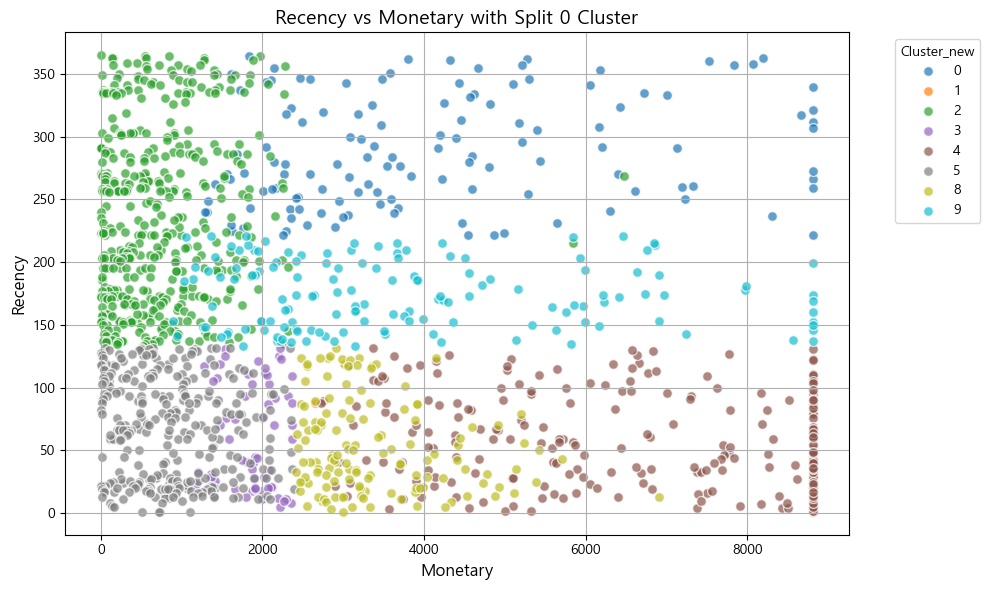

In [38]:
# 기존 군집 중 1군집과 3군집에 대해서만 새로운 군집을 형성하는 함수
def create_new_clusters_based_on_conditions(row):
    # 군집 1과 3에 대해서만 새로운 군집 기준 적용
    if row['Cluster_n'] == 1 or row['Cluster_n'] == 3 or row['Cluster_n'] == 0:  # 1군집 또는 3군집
        # 1군집에 대한 조건
        if row['Cluster_n'] == 1:
            if row['M'] < 3:
                return "5"  # 군집 1의 새로운 군집 1
            if row['M'] == 3 and row['R'] == 2:
                return "6"  # 군집 1의 새로운 군집 2
            elif row['M'] == 4 and row['R'] <=2:
                return "7"  # 군집 1의 새로운 군집 3
        
        # 3군집에 대한 조건
        elif row['Cluster_n'] == 3:
            if row['M'] == 3:
                return "8"  # 군집 3의 새로운 군집 4
        
        elif row['Cluster_n'] == 0:
            if row['R'] ==2:
                return "9"  # 군집 0의 새로운 군집 6
            
        # 조건을 만족하지 않으면 기존 군집을 유지
        return row['Cluster_n']
    
    else:
        # 1군집과 3군집이 아니면 기존 군집 유지
        return row['Cluster_n']

# 새로운 군집 값을 적용
cust['Cluster_new'] = cust.apply(create_new_clusters_based_on_conditions, axis=1)

# Cluster_new 값을 문자열로 변환하여 정렬
cust['Cluster_new'] = cust['Cluster_new'].astype(str)

# 시각화: 'Monetary'와 'Recency' 기준으로 재분류된 클러스터를 표현
plt.figure(figsize=(10, 6))
unique_clusters = sorted(cust['Cluster_new'].unique(), key=lambda x: (x.isdigit(), x))  # 숫자 먼저, 문자열 그다음 정렬
colors = plt.cm.get_cmap('tab10', len(unique_clusters))

# 클러스터별로 산점도 플롯
for i, cluster in enumerate(unique_clusters):
    subset = cust[cust['Cluster_new'] == cluster]
    plt.scatter(subset['Monetary'], subset['Recency'], s=50, 
                color=colors(i), label=cluster, alpha=0.7, edgecolors='w')

# 그래프 설정
plt.xlabel('Monetary', fontsize=12)
plt.ylabel('Recency', fontsize=12)
plt.title('Recency vs Monetary with Split 0 Cluster', fontsize=14)
plt.legend(title="Cluster_new", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
cust['Cluster_new'].value_counts()

Cluster_new
2    453
5    292
4    251
9    146
8    137
0    128
3     60
1      1
Name: count, dtype: int64

In [40]:
mapping = {'0':'2', '1':'0','2':'3','3':'4','4':'1'}
cust['Cluster_new'] = cust['Cluster_new'].replace(mapping)

In [41]:
mapping = {'0':'2', '1':'0','2':'3','3':'4','4':'1'}
cust['Cluster_n'] = cust['Cluster_n'].replace(mapping)

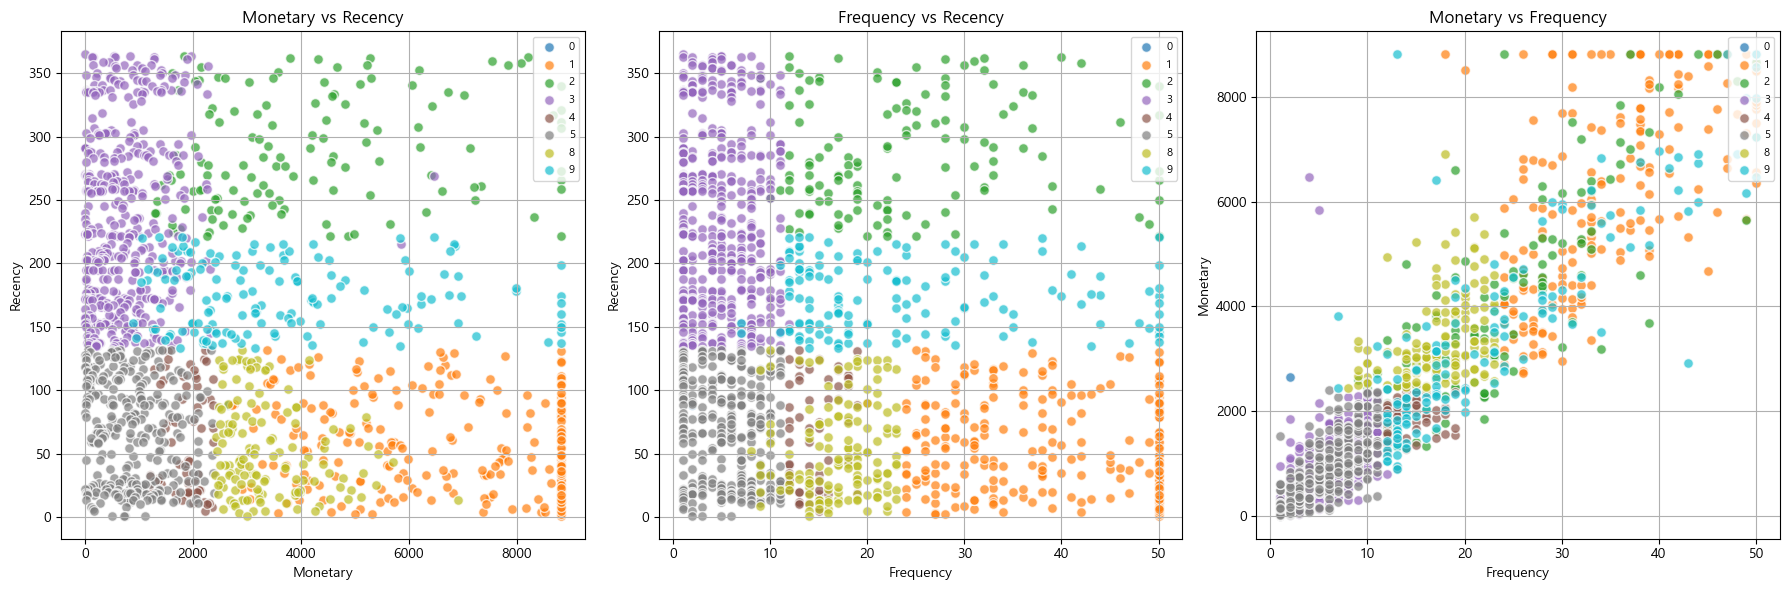

In [42]:
# 클러스터를 오름차순으로 정렬
unique_clusters = sorted(cust['Cluster_new'].unique(), key=lambda x: str(x))

# 시각화: Monetary vs Recency, Frequency vs Recency, Monetary vs Frequency
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 한 행에 3개의 그래프
axes = axes.flatten()  # 1차원 배열로 변환

# 그래프의 x축과 y축 조합
plot_settings = [
    ('Monetary', 'Recency', 'Monetary vs Recency'),
    ('Frequency', 'Recency', 'Frequency vs Recency'),
    ('Frequency','Monetary',  'Monetary vs Frequency')
]

colors = plt.cm.get_cmap('tab10', len(unique_clusters))  # 클러스터에 따른 색상 설정

for i, (x_col, y_col, title) in enumerate(plot_settings):
    scatter_handles = []  # 각 subplot의 범례 핸들 저장
    for j, cluster in enumerate(unique_clusters):
        subset = cust[cust['Cluster_new'] == cluster]
        scatter = axes[i].scatter(subset[x_col], subset[y_col], 
                                  s=50, color=colors(j), label=cluster, 
                                  alpha=0.7, edgecolors='w')
        scatter_handles.append(scatter)  # 핸들 저장
    
    # 각 subplot 제목, 축 레이블, 범례 설정
    axes[i].set_title(title, fontsize=12)
    axes[i].set_xlabel(x_col, fontsize=10)
    axes[i].set_ylabel(y_col, fontsize=10)
    axes[i].grid(True)
    axes[i].legend(handles=scatter_handles, loc='upper right', fontsize=8)

# 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('three_scatterplots.png', dpi=300)
plt.show()


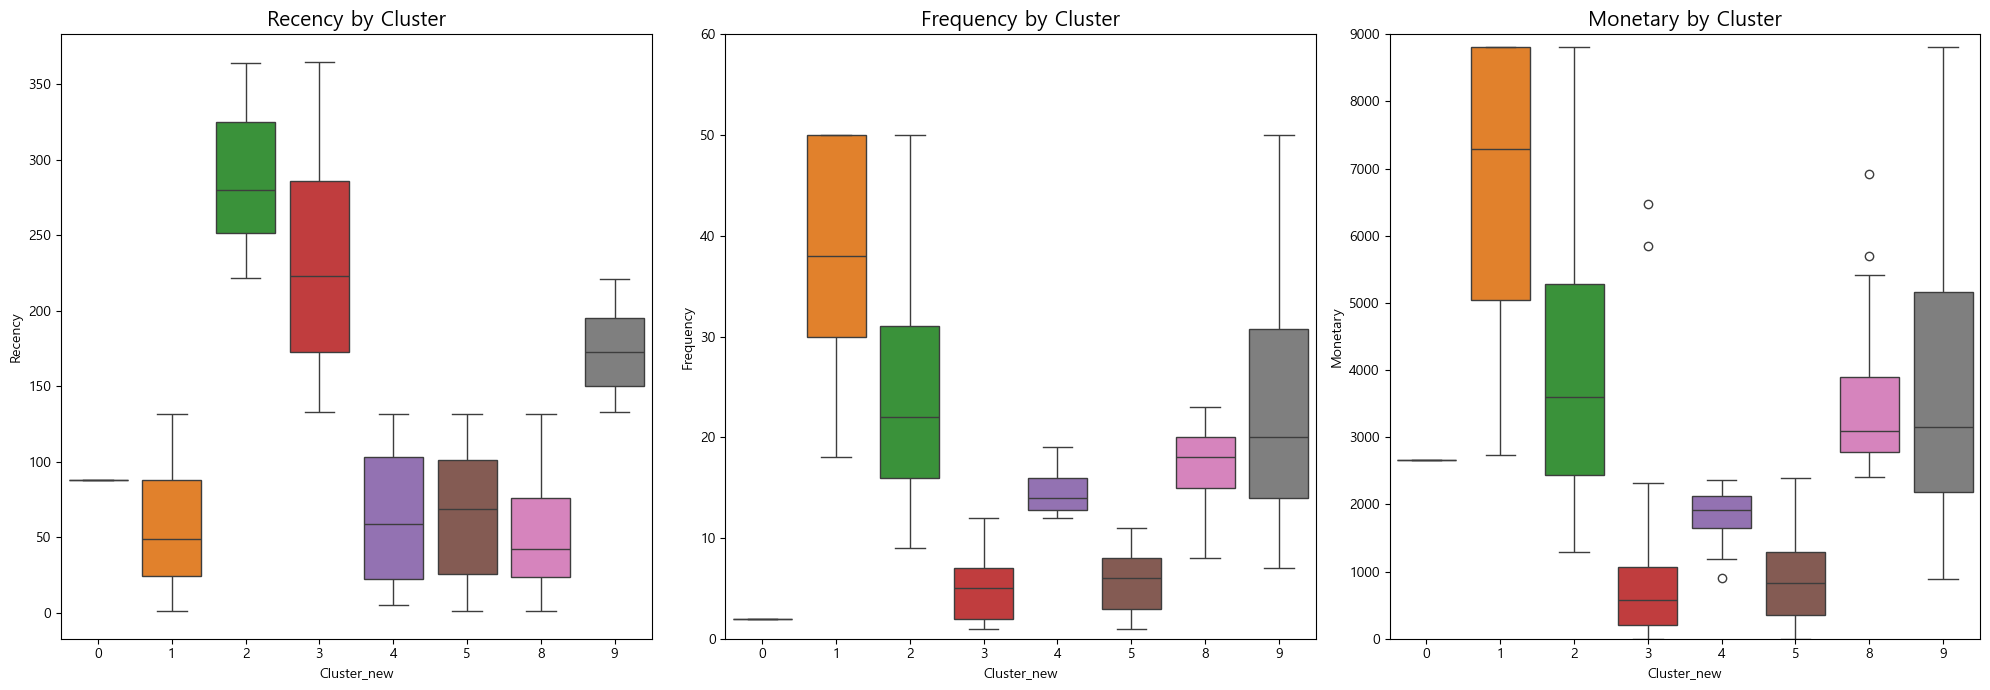

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 예시 데이터프레임 설정 (cust를 사용한다고 가정)
# cust['Cluster_new']를 정렬된 카테고리형으로 변환
cust['Cluster_new'] = pd.Categorical(cust['Cluster_new'], categories=sorted(cust['Cluster_new'].unique()), ordered=True)

# 시각화 설정
fig, axs = plt.subplots(ncols=3, figsize=(20, 7))

# Recency에 대한 박스플롯
sns.boxplot(data=cust, x='Cluster_new', y='Recency', ax=axs[0], palette="tab10")
axs[0].set_title('Recency by Cluster', fontsize=15)
axs[0].set_xlabel('Cluster_new')
axs[0].set_ylabel('Recency')

# Frequency에 대한 박스플롯
sns.boxplot(data=cust, x='Cluster_new', y='Frequency', ax=axs[1], palette="tab10")
axs[1].set_title('Frequency by Cluster', fontsize=15)
axs[1].set_xlabel('Cluster_new')
axs[1].set_ylabel('Frequency')
axs[1].set_ylim(0, 60)

# Monetary에 대한 박스플롯
sns.boxplot(data=cust, x='Cluster_new', y='Monetary', ax=axs[2], palette="tab10")
axs[2].set_title('Monetary by Cluster', fontsize=15)
axs[2].set_xlabel('Cluster_new')
axs[2].set_ylabel('Monetary')
axs[2].set_ylim(0, 9000)

# 레이아웃 조정
plt.tight_layout()
plt.show()


In [44]:
unique_clusters

['0', '1', '2', '3', '4', '5', '8', '9']

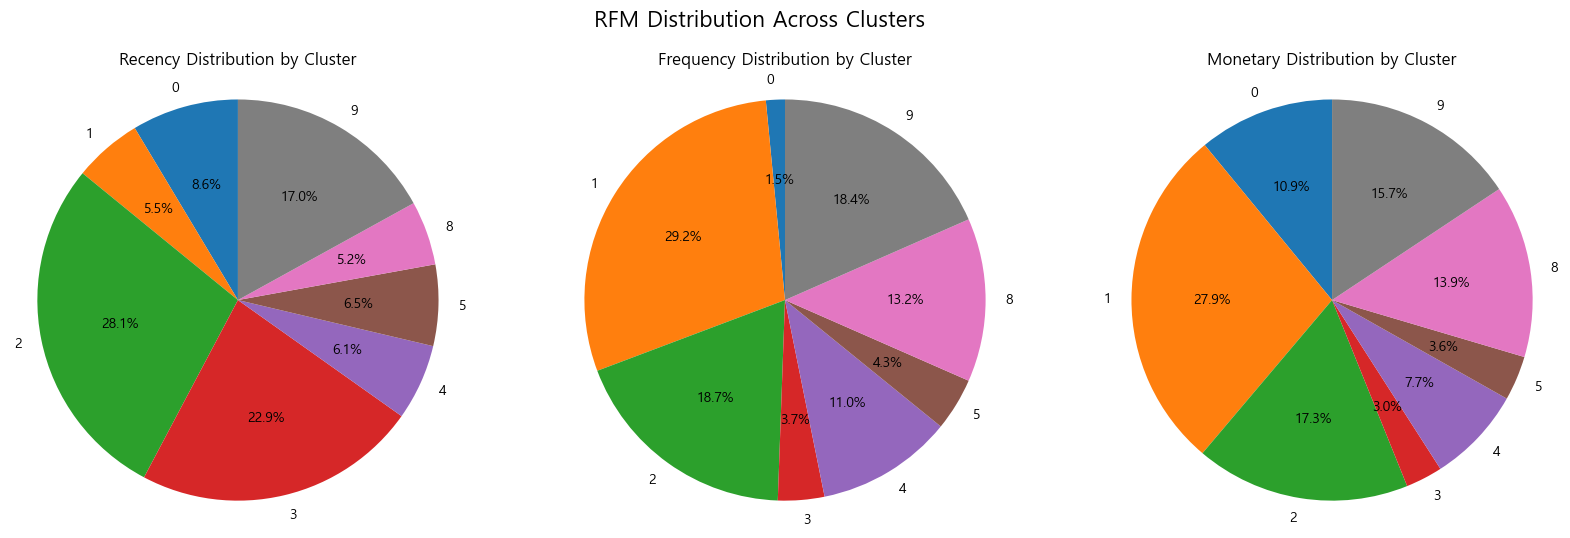

In [45]:
import matplotlib.pyplot as plt

# 클러스터별 평균 RFM 값 가져오기
cluster_avg = cust[['Recency', 'Frequency', 'Monetary','Cluster_new']].groupby('Cluster_new').mean()

# 각 RFM 컬럼을 클러스터의 평균으로 나누어 정규화
cluster_avg_norm = cluster_avg.div(cluster_avg.sum(axis=0), axis=1)

# 원형 차트 생성
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    ax[i].pie(cluster_avg_norm[col], labels=cluster_avg_norm.index, autopct='%1.1f%%', startangle=90,radius=1.1)
    ax[i].set_title(f'{col} Distribution by Cluster')

plt.suptitle('RFM Distribution Across Clusters', fontsize=16)
plt.show()

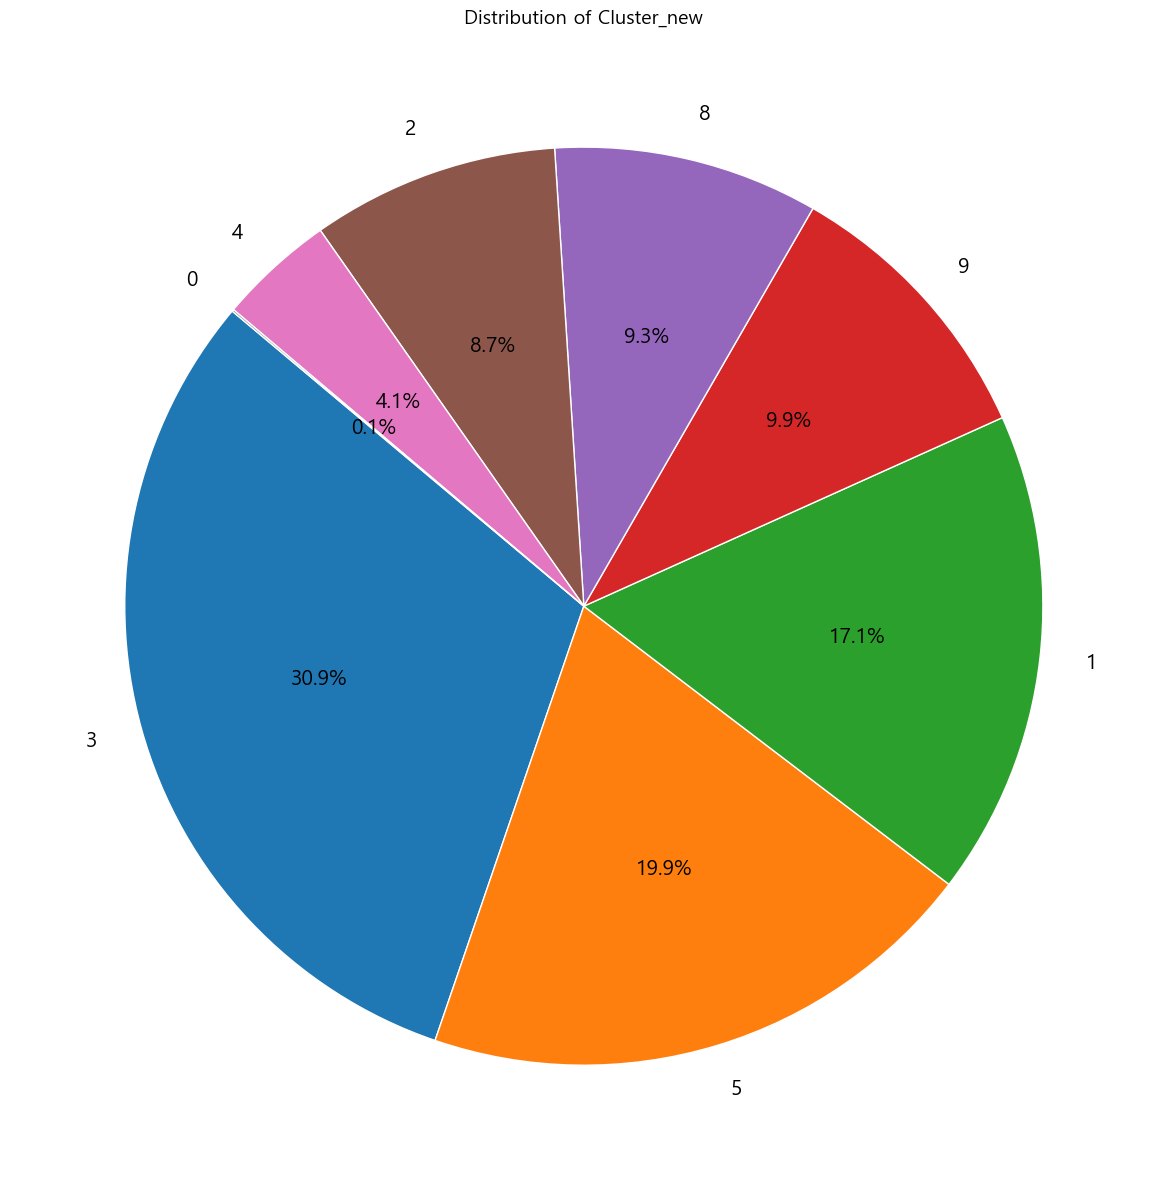

In [46]:
import matplotlib.pyplot as plt

# Cluster_new의 관측치 개수를 집계
cluster_counts = cust['Cluster_new'].value_counts()

# 파이차트 그리기
plt.figure(figsize=(12, 12))
colors = plt.cm.tab10.colors  # 색상 설정

plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=colors[:len(cluster_counts)], wedgeprops={'edgecolor': 'white'},textprops={'fontsize': 15})

# 제목 및 설정
plt.title('Distribution of Cluster_new', fontsize=14)
plt.tight_layout()
plt.show()


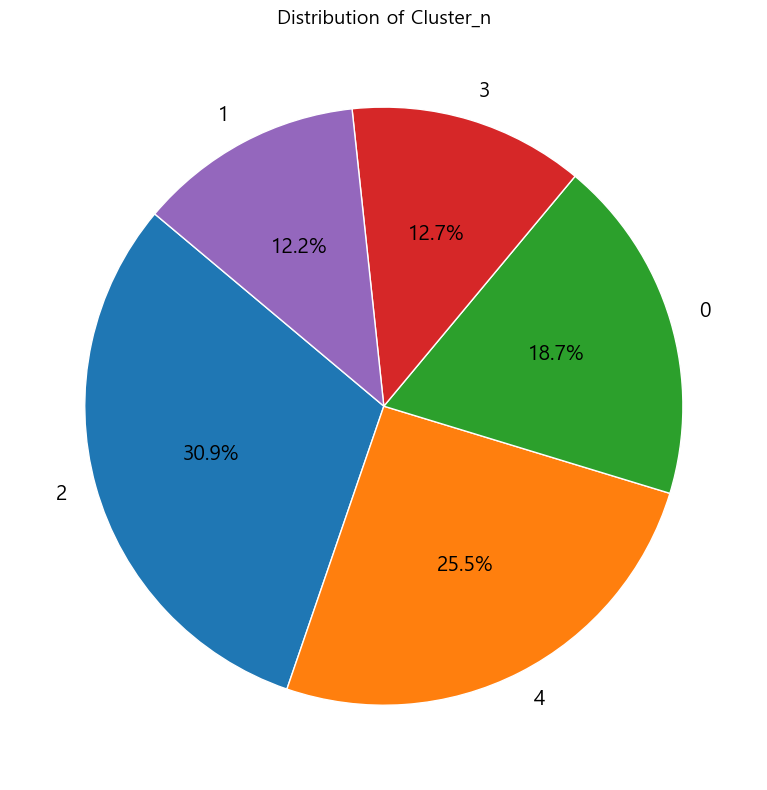

In [61]:
import matplotlib.pyplot as plt

# Cluster_n 값 변환
mapping = {'0': '2', '1': '0', '2': '3', '3': '4', '4': '1'}
cust['Cluster_n'] = cust['Cluster_n'].astype(str).map(mapping)  # mapping 적용

# Cluster_n의 관측치 개수를 집계
cluster_counts = cust['Cluster_n'].value_counts()

# 파이차트 그리기
plt.figure(figsize=(8, 8))
colors = plt.cm.tab10.colors  # 색상 설정

plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=colors[:len(cluster_counts)], wedgeprops={'edgecolor': 'white'}, textprops={'fontsize': 15})

# 제목 및 설정
plt.title('Distribution of Cluster_n', fontsize=14)
plt.tight_layout()
plt.show()


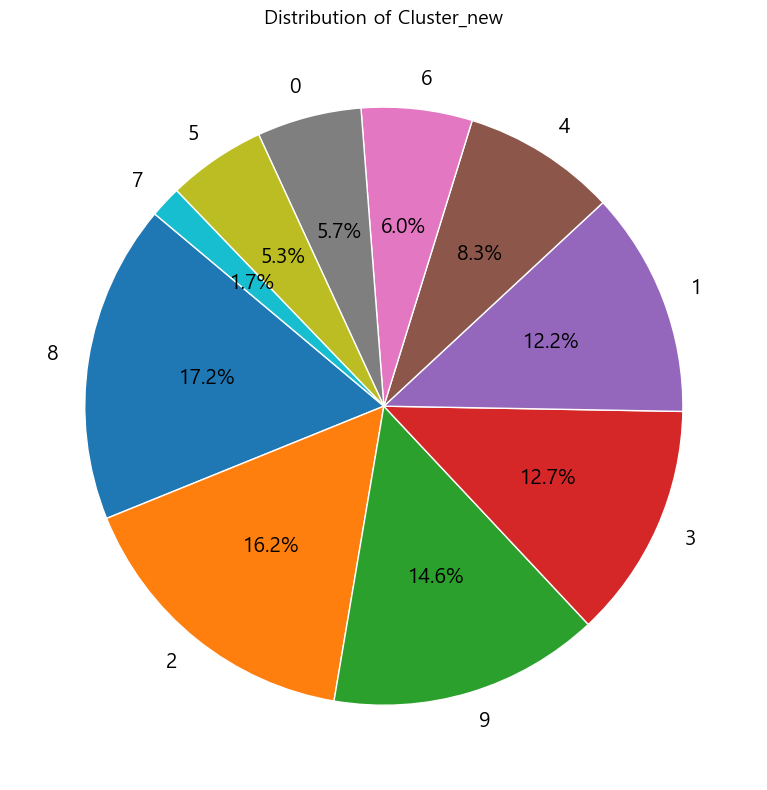

In [62]:
import matplotlib.pyplot as plt

# Cluster_new의 관측치 개수를 집계
cluster_counts = cust['Cluster_new'].value_counts()

# 파이차트 그리기
plt.figure(figsize=(8, 8))
colors = plt.cm.tab10.colors  # 색상 설정

plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=colors[:len(cluster_counts)], wedgeprops={'edgecolor': 'white'},textprops={'fontsize': 15})

# 제목 및 설정
plt.title('Distribution of Cluster_new', fontsize=14)
plt.tight_layout()
plt.show()


In [63]:
def assign_segment(row):
    # VIP 고객
    if row['R'] in {3, 4} and row['F'] in {3, 4} and row['M'] == 4:
        return "VIP 고객"
    # 이탈 위험 큰손 고객
    elif row['R'] in {1, 2, 3} and row['F'] in {1, 2, 3, 4} and row['M'] == 4:
        return "이탈 위험 큰손 고객"
    # 큰손 신규 고객
    elif row['R'] == 4 and row['F'] in {1, 2, 3, 4} and row['M'] in {3, 4}:
        return "큰손 신규 고객"
    # 충성 고객
    elif row['R'] in {3, 4} and row['F'] in {3, 4} and row['M'] in {1, 2, 3}:
        return "충성 고객"
    # 이탈 위험 충성 고객
    elif row['R'] == 1 and row['F'] in {2, 3, 4} and row['M'] in {1, 2, 3}:
        return "이탈 위험 충성 고객"
    # 일반 고객
    elif row['R'] in {2, 3} and row['F'] in {1, 2} and row['M'] in {2, 3}:
        return "일반 고객"
    # 잠재 고객
    elif row['R'] in {3, 4} and row['F'] in {1, 2} and row['M'] in {1, 2}:
        return "잠재 고객"
    # 휴면 고객
    elif row['R'] == 1 and row['F'] in {1, 2} and row['M'] in {1, 2}:
        return "휴면 고객"
    # 기타
    else:
        return "기타"

# 세그먼트 라벨링
cust['segment'] = cust.apply(assign_segment, axis=1)

# 결과 확인 (각 세그먼트의 비율 계산)
segment_distribution = cust['segment'].value_counts(normalize=True) * 100
print(segment_distribution)


기타             18.664850
잠재 고객          14.645777
이탈 위험 충성 고객    13.555858
충성 고객          12.261580
일반 고객          10.967302
휴면 고객          10.354223
큰손 신규 고객        9.536785
VIP 고객          8.310627
이탈 위험 큰손 고객     1.702997
Name: segment, dtype: float64


In [64]:
cust['segment'].value_counts()

기타             274
잠재 고객          215
이탈 위험 충성 고객    199
충성 고객          180
일반 고객          161
휴면 고객          152
큰손 신규 고객       140
VIP 고객         122
이탈 위험 큰손 고객     25
Name: segment, dtype: int64

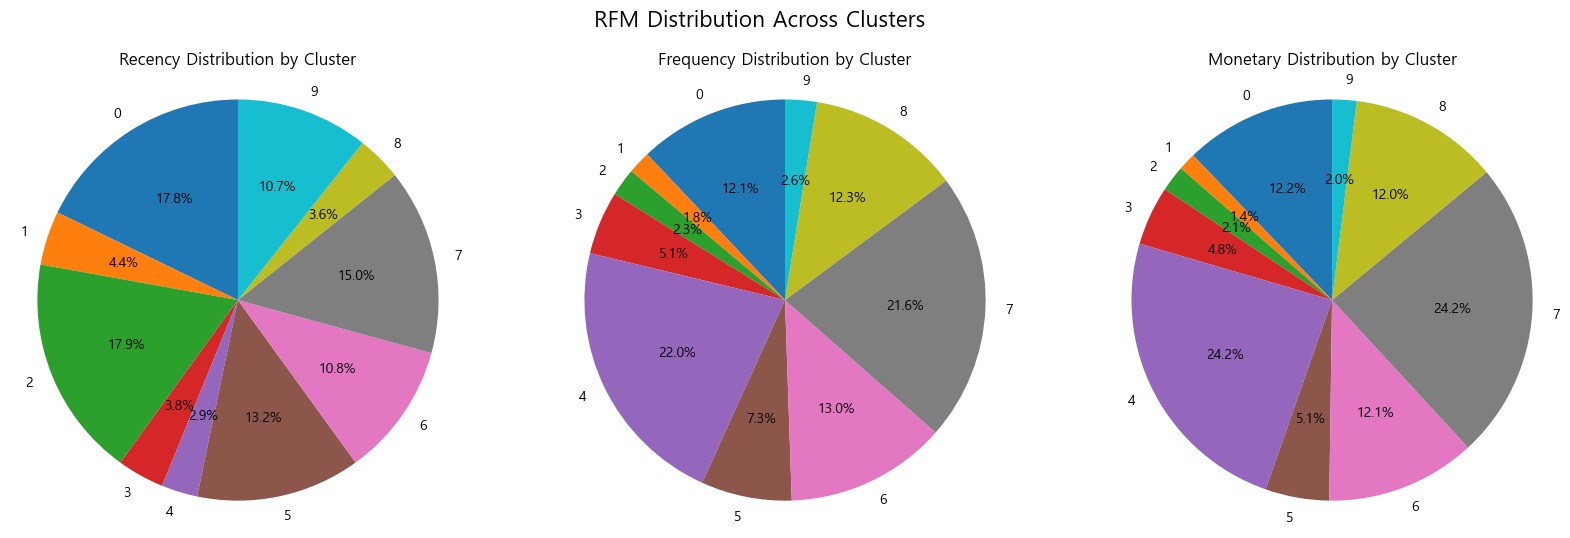

In [65]:
import matplotlib.pyplot as plt

# 클러스터별 평균 RFM 값 가져오기
cluster_avg = cust[['Recency', 'Frequency', 'Monetary','Cluster_new']].groupby('Cluster_new').mean()

# 각 RFM 컬럼을 클러스터의 평균으로 나누어 정규화
cluster_avg_norm = cluster_avg.div(cluster_avg.sum(axis=0), axis=1)

# 원형 차트 생성
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    ax[i].pie(cluster_avg_norm[col], labels=cluster_avg_norm.index, autopct='%1.1f%%', startangle=90,radius=1.1)
    ax[i].set_title(f'{col} Distribution by Cluster')

plt.suptitle('RFM Distribution Across Clusters', fontsize=16)
plt.show()

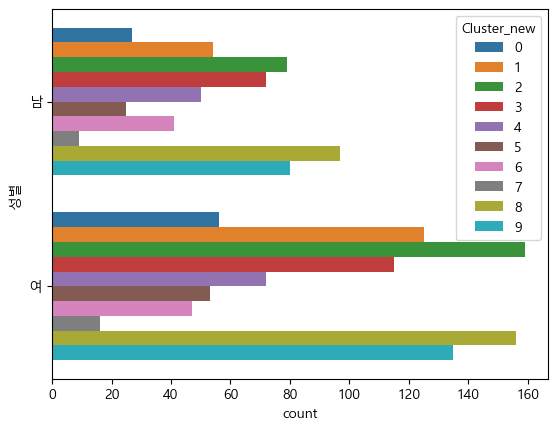

In [66]:
sns.countplot(data=cust, y='성별', palette="tab10",hue="Cluster_new")
plt.show()

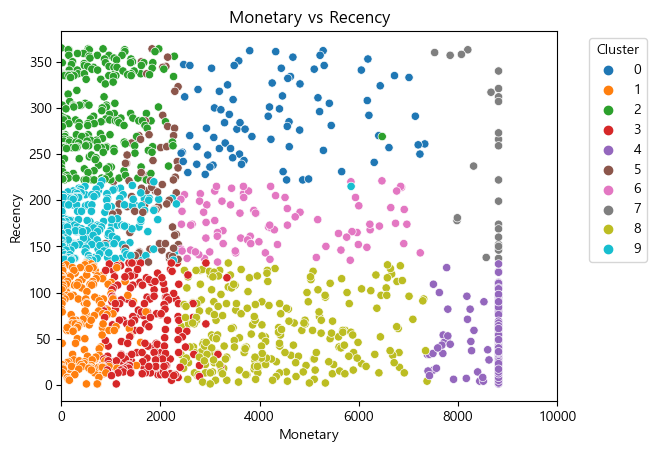

In [67]:
sns.scatterplot(x= cust['Monetary'], y=cust['Recency'], hue = cust.Cluster_new,  palette='tab10')
plt.title('Monetary vs Recency')  # 제목 추가
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xlim(0, 10000)
plt.show()

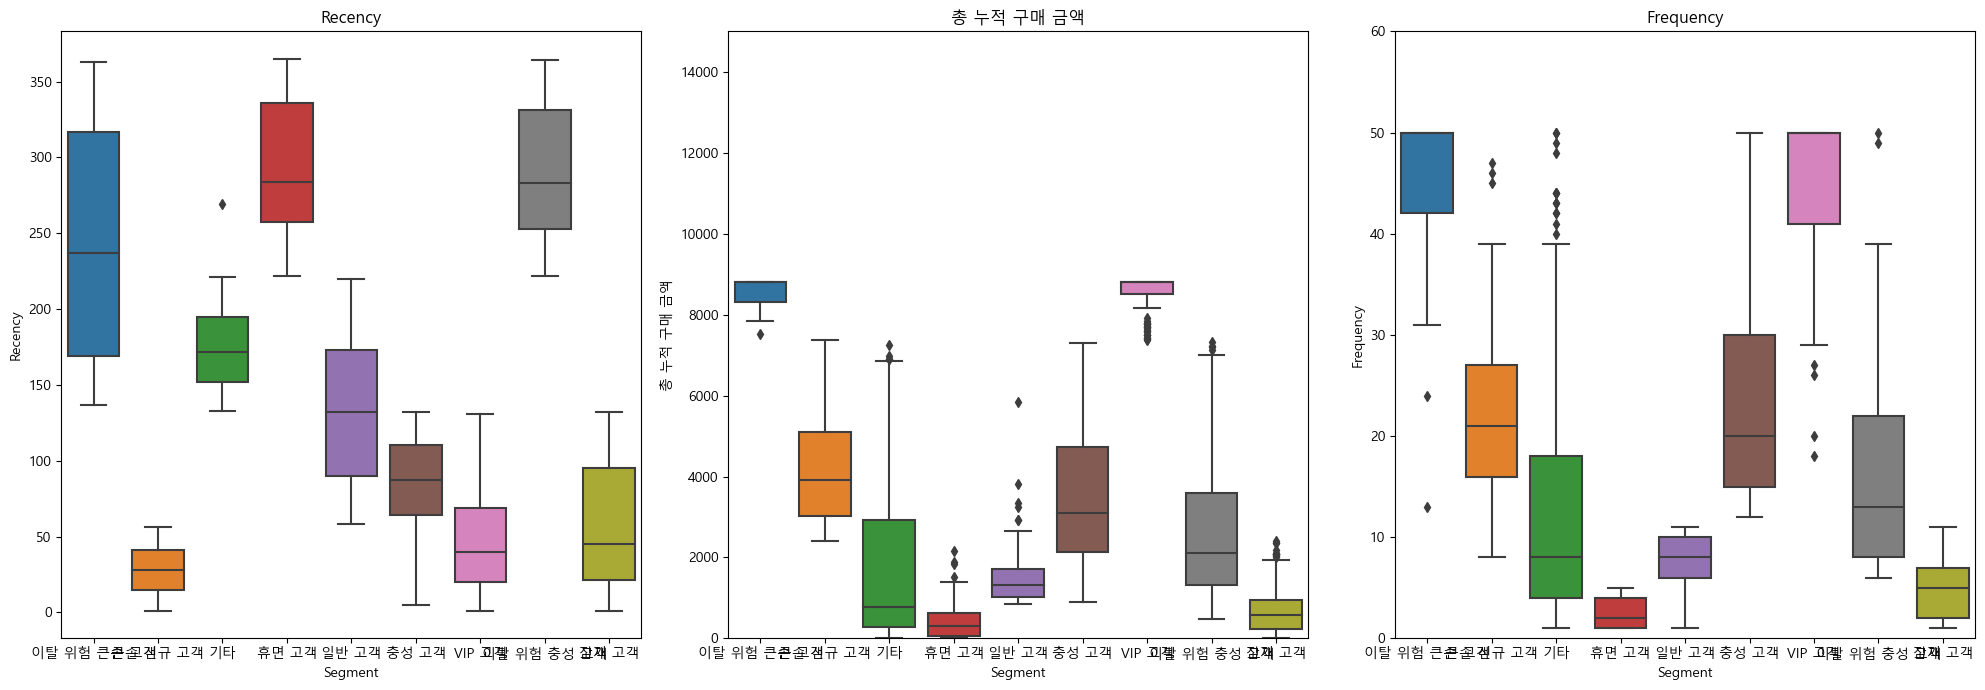

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
fig, axs = plt.subplots(ncols=3, figsize=(20, 7))

# Recency에 대한 박스플롯
sns.boxplot(data=cust, x='segment', y='Recency', ax=axs[0])
axs[0].set_title('Recency')
axs[0].set_xlabel('Segment')
axs[0].set_ylabel('Recency')

# Monetary에 대한 박스플롯
sns.boxplot(data=cust, x='segment', y='Monetary', ax=axs[1])
axs[1].set_title('총 누적 구매 금액')
axs[1].set_xlabel('Segment')
axs[1].set_ylabel('총 누적 구매 금액')
axs[1].set_ylim(0, 15000)  # 필요 시 범위 조정

# Frequency에 대한 박스플롯
sns.boxplot(data=cust, x='segment', y='Frequency', ax=axs[2])
axs[2].set_title('Frequency')
axs[2].set_xlabel('Segment')
axs[2].set_ylabel('Frequency')
axs[2].set_ylim(0, 60)  # 필요 시 범위 조정

# 레이아웃 조정
plt.tight_layout()
plt.show()


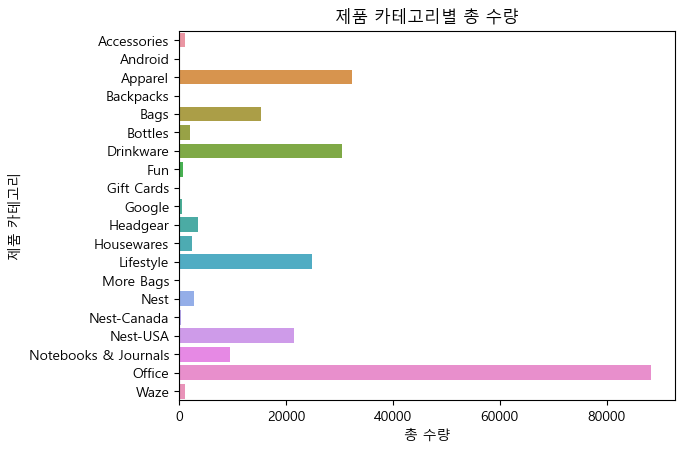

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# 제품 카테고리별 총 수량 계산
category_counts = O_sale.groupby('제품카테고리')['수량'].sum().reset_index()

# 막대 그래프 그리기
sns.barplot(data=category_counts, x='수량', y='제품카테고리', orient='h')  # 가로 막대
plt.xlabel('총 수량')  # x축 라벨
plt.ylabel('제품 카테고리')  # y축 라벨
plt.title('제품 카테고리별 총 수량')  # 그래프 제목
plt.show()

In [77]:
O_sale = O_sale.merge(cust[['고객ID','Cluster_new']], on='고객ID', how='left')

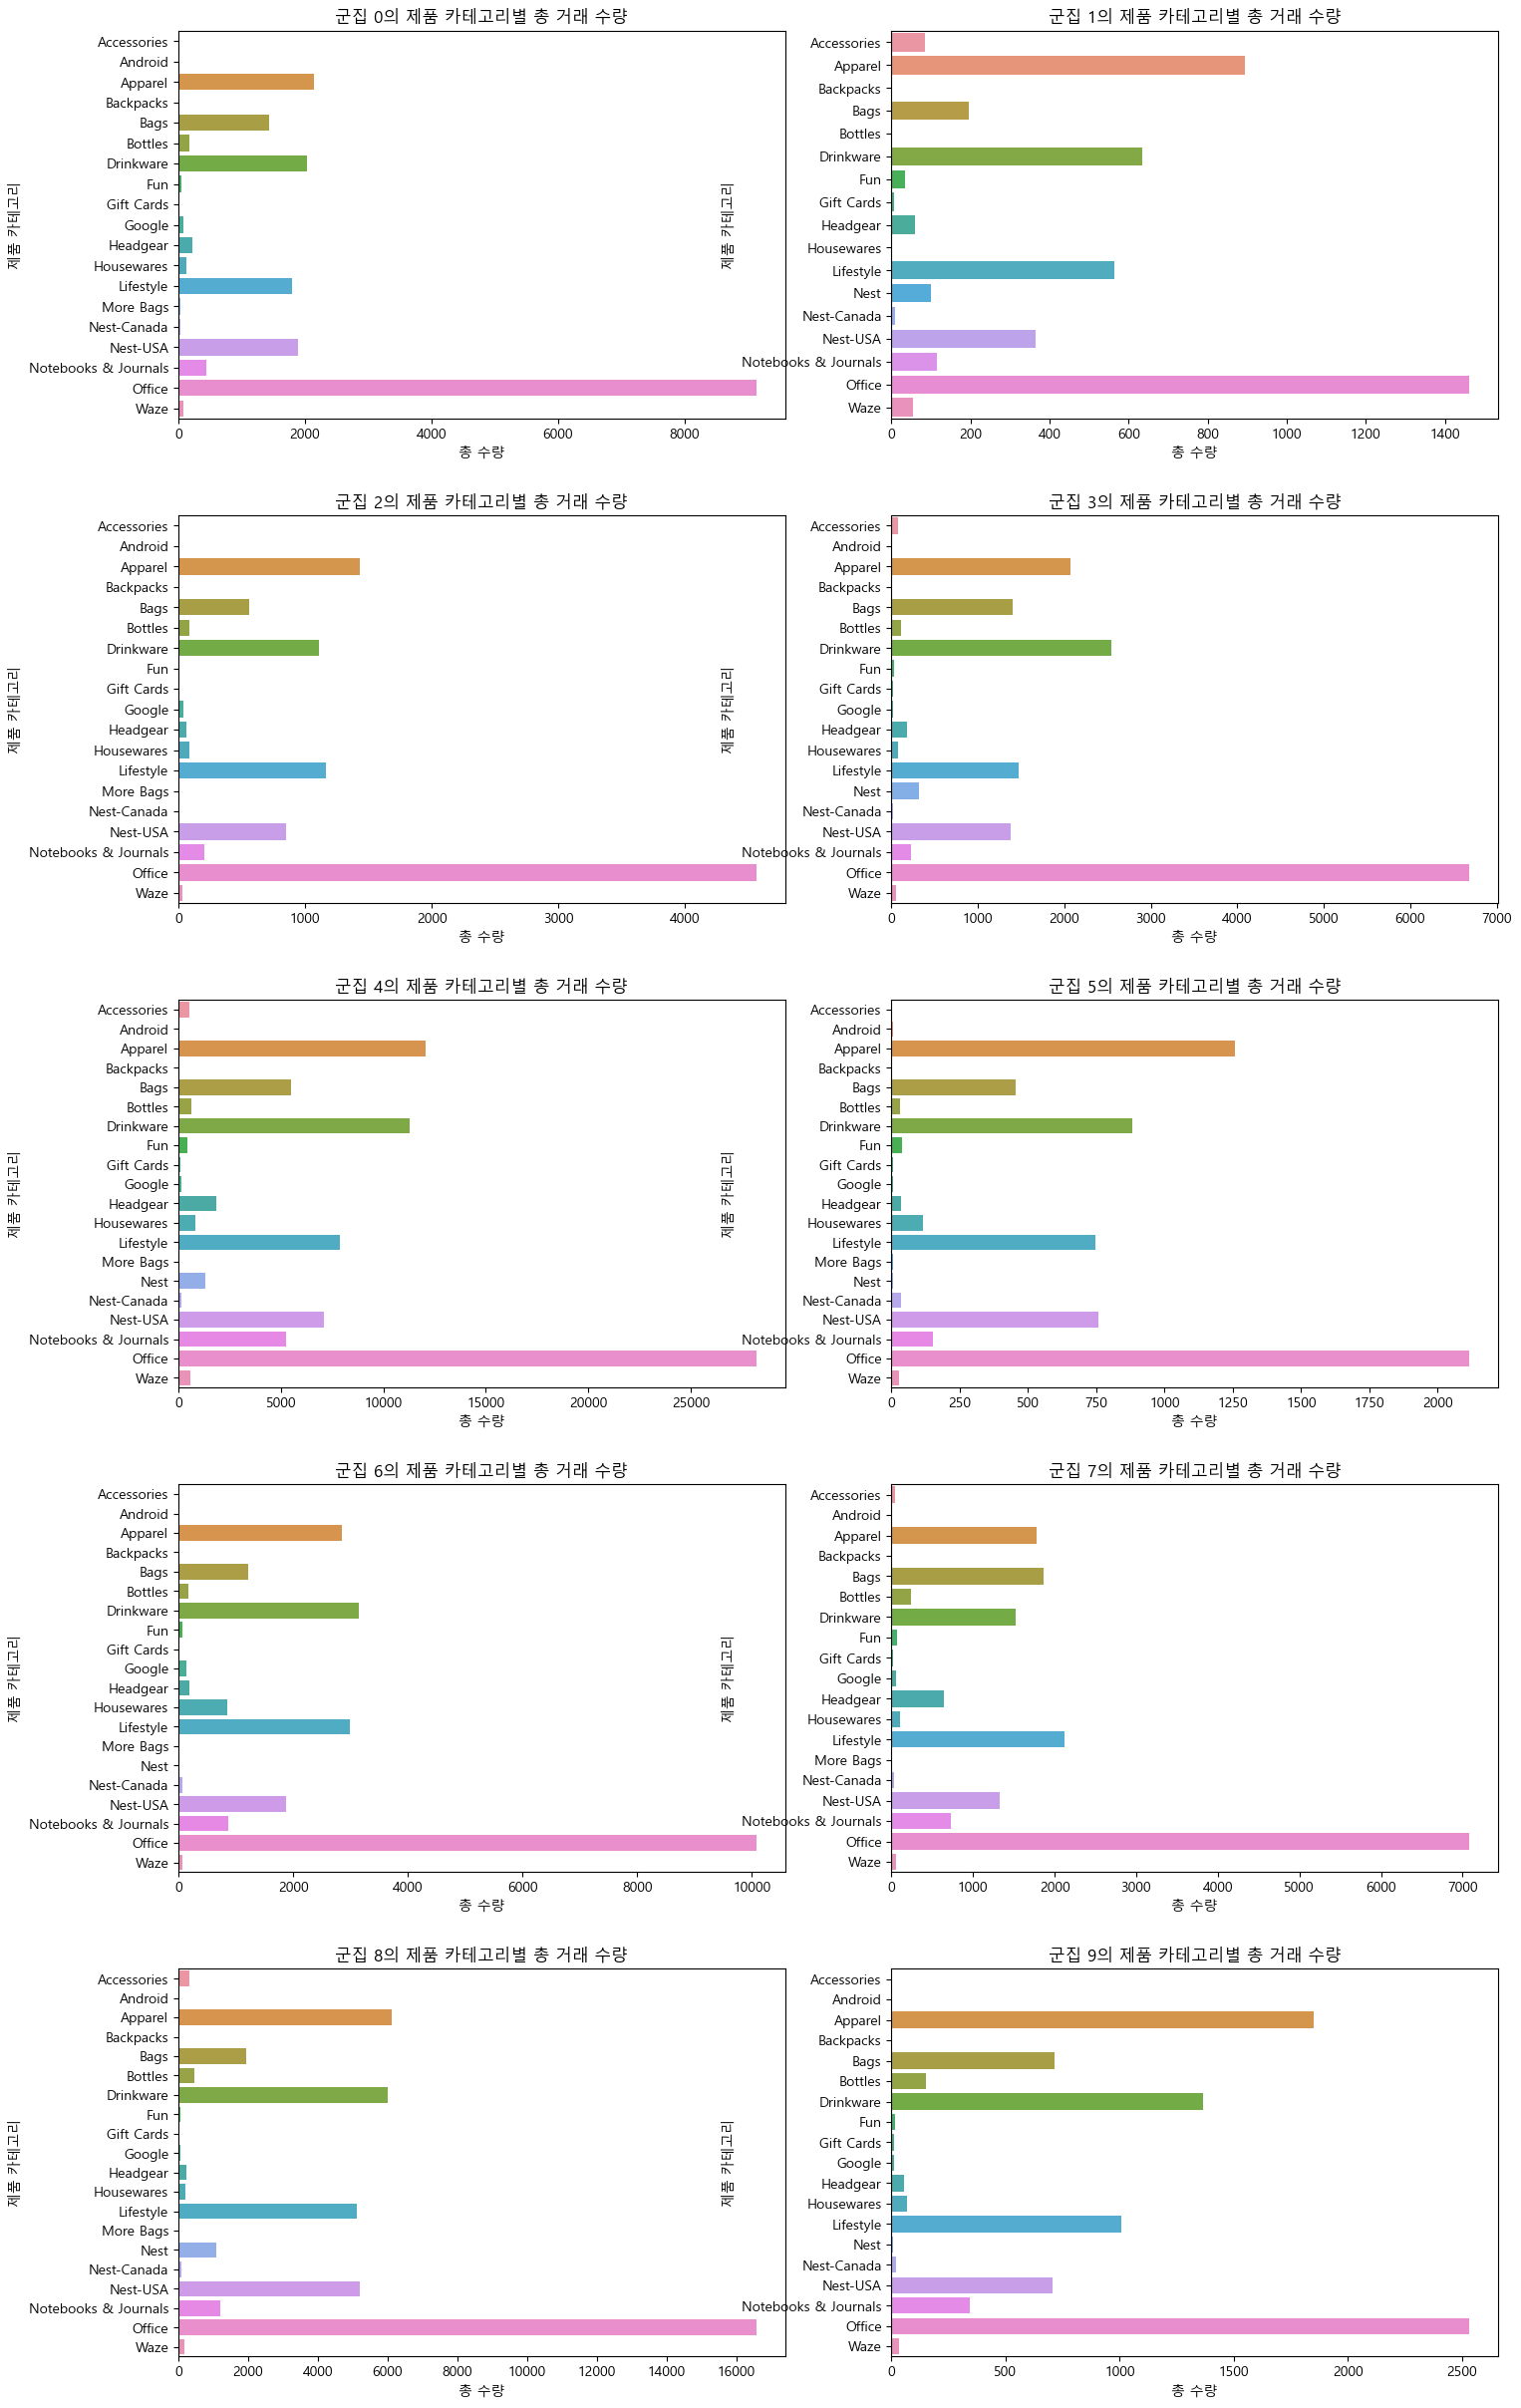

In [78]:
O_sale.Cluster_new = O_sale.Cluster_new.astype(int)
# 서브플롯 설정: 5행 2열
fig, axes = plt.subplots(5, 2, figsize=(15, 25))  # 총 10개의 군집을 5x2로 배치
fig.tight_layout(pad=5.0)  # 그래프 간격 조정

# 군집별 그래프 생성
for cluster in range(10):
    ax = axes[cluster // 2, cluster % 2]  # 5행 2열 인덱스 계산
    cluster_data = O_sale[O_sale['Cluster_new'] == cluster]  # 특정 군집 데이터 필터링
    category_counts = cluster_data.groupby('제품카테고리')['수량'].sum().reset_index()

    if not category_counts.empty:
        sns.barplot(data=category_counts, x='수량', y='제품카테고리', orient='h', ax=ax)
        ax.set_title(f'군집 {cluster}의 제품 카테고리별 총 거래 수량')
        ax.set_xlabel('총 수량')
        ax.set_ylabel('제품 카테고리')
    else:
        ax.set_title(f'군집 {cluster} 데이터 없음')
        ax.axis('off')  # 데이터가 없는 경우 축 제거

plt.savefig('cluster_category_counts.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
bins = [0, 12, 24, 36, float('inf')]  # 0 이상 2 미만, 2 이상 5 미만, 5 이상
labels = [ 1,2,3,4 ]  # 각 구간에 대한 범주 이름

# pd.cut()을 사용하여 범주화
cust['duration'] = pd.cut(cust['가입기간'], bins=bins, labels=labels, right=False)  # right=False는 상한값을 제외

In [81]:
cust['duration'] = cust['duration'].astype(int)

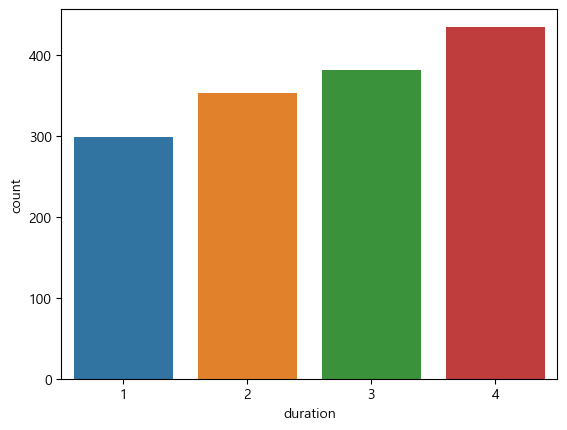

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(data=cust, x='duration', palette="tab10")
plt.show()
#매년 신규 유입고객이 줄어들고 있음

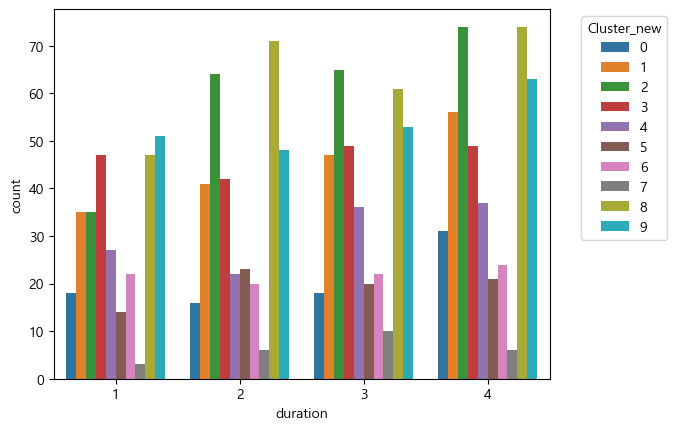

In [83]:
sns.countplot(data=cust, x='duration', palette="tab10",hue="Cluster_new")
plt.legend(title="Cluster_new", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()